# AGC Training Demonstration
________

This notebook demonstrates a workflow for training a BDT with MLFlow logging and model storage at a coffea-casa analysis facility. The ML task shown here is simple signal/background classification, which was chosen for this demonstration so that we can focus on the technical aspects of the workflow. As such, the task and the features used are not necessarily well-motivated from a physics standpoint. This is a precursor to a talk at CHEP 2023, which will demonstrate both training and inference at coffea-casa analysis facility in the AGC context, using a BDT which predicts parton association of the jet in an event in order to provide more sophisticated event variables for the ttbar cross-section measurement. To avoid dealing with background cross-sections, the background samples are restricted to wjets.

The steps in this notebook are as follows:
1. Process ROOT files into feature and label columns using coffea + dask
2. Prepare columns for training
    - Separate dataset into training and testing samples (even and odd event numbers)
    - Preprocess features using `sklearn` PowerTransformer
3. Train BDTs for each event sample and perform hyperparameter optimization
    - Perform hyperparameter optimization by random sample method, using n-fold cross-validation
    - Use distributed dask to parallelize
    - Log training results for each trial in MLFlow
    - Log models for each trial in MLFlow
4. Test and register models
    - Test each model against the appropriate test sample (even/odd event numbers)
    - Register best model in MLFlow model repository
    - Generate NVIDIA Triton model config file and move to Triton inference server (this last step will eventually become more automated using the triton-mlflow plugin)

___
### Imports

In [1]:
import awkward as ak
import hist
import matplotlib.pyplot as plt
import numpy as np
import uproot
import time
import os

# initial coffea processing
from coffea import processor
from coffea.processor import servicex
from coffea.nanoevents import NanoAODSchema

# for training/hyperparameter ioptimization
from dask.distributed import Client, LocalCluster
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import ParameterSampler, train_test_split, KFold, cross_validate
import mlflow
from mlflow.models.signature import infer_signature
from mlflow.tracking import MlflowClient
from xgboost import XGBClassifier

import utils  # contains code for bookkeeping and cosmetics, as well as some boilerplate

/opt/conda/lib/python3.8/site-packages/requests/__init__.py:102: RequestsDependencyWarning: urllib3 (1.26.7) or chardet (5.0.0)/charset_normalizer (2.0.9) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({})/charset_normalizer ({}) doesn't match a supported "


___
### Configuration

The configuration options below are separated into two categories: those used for processing the feature set, and those used for ML.

In [2]:
### FILE PROCESSING OPTIONS

# input files per process (ttbar and wjets)
N_FILES_MAX_PER_SAMPLE = 1

# enable Dask (essentially whether to use DaskExecutor or FuturesExecutor with coffea)
USE_DASK_PROCESSING = True

# analysis facility: set to "coffea_casa" for coffea-casa environments, "EAF" for FNAL, "local" for local setups
AF = "coffea_casa"

# chunk size to use for file processing
CHUNKSIZE = 250_000

# "ssl-dev" allows for the switch to local data on /data
AF_NAME = "coffea_casa"  # "ssl-dev" allows for the switch to local data on /data

# scaling for local setups with FuturesExecutor
NUM_CORES = 8


### MACHINE LEARNING OPTIONS

# enable Dask (whether to use dask for hyperparameter optimization)
USE_DASK_ML = True

# enable MLFlow logging (to store metrics and models of hyperparameter optimization trials)
USE_MLFLOW = True

# enable MLFlow model logging/registering
MODEL_LOGGING = False

# number of folds for cross-validation
N_FOLD = 5

# number of trials (per model) for hyperparameter optimization. Total number of trials will be 2*N_TRIALS
N_TRIALS = 20

# number of events to use for training (choose smaller number, i.e. 10000, for quick demo)
N_TRAIN = 10000

# name to use for saving model to triton server
MODEL_NAME = "sigbkg_bdt"

# if True, write over previous versions of model in triton directory
WRITE_OVER = True

___
### Defining the `coffea` Processor

This processor returns columns associated with the features and labels we will use to train a BDT to distinguish signal from background events. `coffea`'s column accumulator is utilized. The cuts here are much looser than those used in the AGC ttbar notebook in order to provide ample discrimination power for demonstration purposes.

In [3]:
# function to create column accumulator from list
def col_accumulator(a):
    return processor.column_accumulator(np.array(a))

# coffea processor
class ProcessFeatures(processor.ProcessorABC):
    def __init__(self):
        super().__init__()
        
    def process(self, events):
        
        process = events.metadata["process"]  # "ttbar" or "wjets"
        
        electrons = events.Electron
        muons = events.Muon
        jets = events.Jet
        even = (events.event%2==0) # whether the event number is even

        # single lepton requirement
        event_filters = ((ak.count(electrons.pt, axis=1) + ak.count(muons.pt, axis=1)) == 1)
        # at least four jets
        event_filters = event_filters & (ak.count(jets.pt, axis=1) >= 4)
        # at least one b-tagged jet ("tag" means score above threshold)
        B_TAG_THRESHOLD = 0.5
        event_filters = event_filters & (ak.sum(jets.btagCSVV2 >= B_TAG_THRESHOLD, axis=1) >= 1)

        # apply event filters
        electrons = electrons[event_filters]
        muons = muons[event_filters]
        jets = jets[event_filters]
        even = even[event_filters]
        
        
        ### CALCULATE FEATURES
        
        ## calculate aplanarity and aphericity from sphericity tensor of all jets in event
        
        # sum of jet momentum
        sum_p = ak.sum(jets.p**2, axis=-1) 

        # off-diagonal elements
        Sxy =  np.divide(ak.sum(np.multiply(jets.px, jets.py), axis=-1), sum_p)
        Sxz =  np.divide(ak.sum(np.multiply(jets.px, jets.pz), axis=-1), sum_p)
        Syz =  np.divide(ak.sum(np.multiply(jets.py, jets.pz), axis=-1), sum_p)
        
        # diagonal elements
        Sxx =  np.divide(ak.sum(jets.px**2, axis=-1), sum_p)
        Syy =  np.divide(ak.sum(jets.py**2, axis=-1), sum_p)
        Szz =  np.divide(ak.sum(jets.pz**2, axis=-1), sum_p)

        # combine elements into sphericity tensor
        flat = np.stack((Sxx,Sxy,Sxz,Sxy,Syy,Syz,Sxz,Syz,Szz),axis=1).to_numpy()
        sphericity_tensor = flat.reshape((flat.shape[0],3,3))

        # find eigenvalues then calculate features
        eigenvalues = ak.sort(np.linalg.eigvals(sphericity_tensor),axis=-1)
        aplanarity = (3/2)*eigenvalues[...,0]
        sphericity = (3/2)*(eigenvalues[...,0]+eigenvalues[...,1])
        
        ## calculate lepton eta and phi (should be one value per event due to single-lepton requirement
        lepton_eta = (ak.sum(electrons.eta,axis=-1) + ak.sum(muons.eta,axis=-1))
        lepton_phi = (ak.sum(electrons.phi,axis=-1) + ak.sum(muons.phi,axis=-1))
        
        ## populate array of features
        features = np.zeros((len(jets),10))
        features[:,0] = ak.num(jets) # number of jets in each event
        features[:,1] = ak.sum(jets.pt, axis=-1) # event HT
        features[:,2] = (ak.sum(electrons.pt,axis=-1) + ak.sum(muons.pt,axis=-1))  # lepton pt
        features[:,3] = jets.nConstituents[...,0] # leading jet number of constituents
        features[:,4] = ak.sum(jets.nConstituents,axis=-1) # total event number of constituents
        features[:,5] = jets.pt[...,0] # leading jet pT
        features[:,6] = aplanarity # aplanarity
        features[:,7] = sphericity # sphericity
        features[:,8] = np.sqrt((lepton_eta-jets.eta[...,0])**2 + 
                                (lepton_phi-jets.phi[...,0])**2) # delta R between leading jet and lepton
        features[:,9] = np.sqrt((jets.eta[...,1]-jets.eta[...,0])**2 + 
                                (jets.phi[...,1]-jets.phi[...,0])**2) # delta R between two leading jets
        
        ### calculate labels (1 for ttbar, 0 for wjets)
        if process=='ttbar':
            labels = np.ones(len(jets))
        else:
            labels = np.zeros(len(jets))
        

        output = {"nevents": {events.metadata["dataset"]: len(jets)}, 
                  "features": col_accumulator(features),
                  "labels": col_accumulator(labels),
                  "even": col_accumulator(even),}

        return output

    def postprocess(self, accumulator):
        return accumulator

___
### "Fileset" construction and metadata

Here, we gather all the required information about the files we want to process: paths to the files and asociated metadata.

In [4]:
fileset = utils.construct_fileset(N_FILES_MAX_PER_SAMPLE, 
                                  use_xcache=False, 
                                  af_name=AF_NAME)  # local files on /data for ssl-dev

# get rid of all processes except ttbar (signal) and wjets (background)
processes = list(fileset.keys())
for process in processes:
    if ((process!="ttbar__nominal") & (process!="wjets__nominal")):
        fileset.pop(process)
fileset

{'ttbar__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/TT_TuneCUETP8M1_13TeV-powheg-pythia8/cmsopendata2015_ttbar_19980_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext3-v1_00000_0000.root'],
  'metadata': {'process': 'ttbar',
   'variation': 'nominal',
   'nevts': 1334428,
   'xsec': 729.84}},
 'wjets__nominal': {'files': ['https://xrootd-local.unl.edu:1094//store/user/AGC/nanoAOD/WJetsToLNu_TuneCUETP8M1_13TeV-amcatnloFXFX-pythia8/cmsopendata2015_wjets_20547_PU25nsData2015v1_76X_mcRun2_asymptotic_v12_ext2-v1_10000_0000.root'],
  'metadata': {'process': 'wjets',
   'variation': 'nominal',
   'nevts': 1249076,
   'xsec': 15487.164}}}

___
### Process Files

In [5]:
NanoAODSchema.warn_missing_crossrefs = False # silences warnings about branches we will not use here

if USE_DASK_PROCESSING:
    executor = processor.DaskExecutor(client=utils.get_client(AF))
else:
    executor = processor.FuturesExecutor(workers=NUM_CORES)

run = processor.Runner(executor=executor, schema=NanoAODSchema, savemetrics=True, metadata_cache={}, 
                       chunksize=CHUNKSIZE, maxchunks=1)
filemeta = run.preprocess(fileset, treename="Events")  # pre-processing
all_columns, metrics = run(fileset, "Events", processor_instance=ProcessFeatures())  # processing

/opt/conda/lib/python3.8/site-packages/distributed/client.py:1288: VersionMismatchWarning: Mismatched versions found

+---------+----------------+----------------+----------------+
| Package | client         | scheduler      | workers        |
+---------+----------------+----------------+----------------+
| python  | 3.8.16.final.0 | 3.8.16.final.0 | 3.8.15.final.0 |
+---------+----------------+----------------+----------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


___
### Inspecting the Features

Let's look at the features we will use for training, comparing signal to background distributions. Note that some of the features we use would need to be appropriately calibrated to use in an actual analysis.

In [6]:
# grab the numpy arrays from the column_accumulator objects
features = all_columns["features"].value
labels = all_columns["labels"].value
even = all_columns["even"].value

In [7]:
### balance signal and background samples

# separate into signal and background regions
features_signal = features[labels==1]
features_background = features[labels==0]
even_signal = even[labels==1]
even_background = even[labels==0]

sb_ratio = len(features_signal)/len(features_background)
print("Initial Sig/Bkg Ratio = ", sb_ratio)

if len(features_signal)>len(features_background):
    features_signal = features_signal[:len(features_background)]
    even_signal = even_signal[:len(features_background)]
    
if len(features_background)>len(features_signal):
    features_background = features_background[:len(features_signal)]
    even_background = even_background[:len(features_signal)]

sb_ratio = len(features_signal)/len(features_background)
print("Final Sig/Bkg Ratio = ", sb_ratio)

Initial Sig/Bkg Ratio =  6.3710530291584835
Final Sig/Bkg Ratio =  1.0


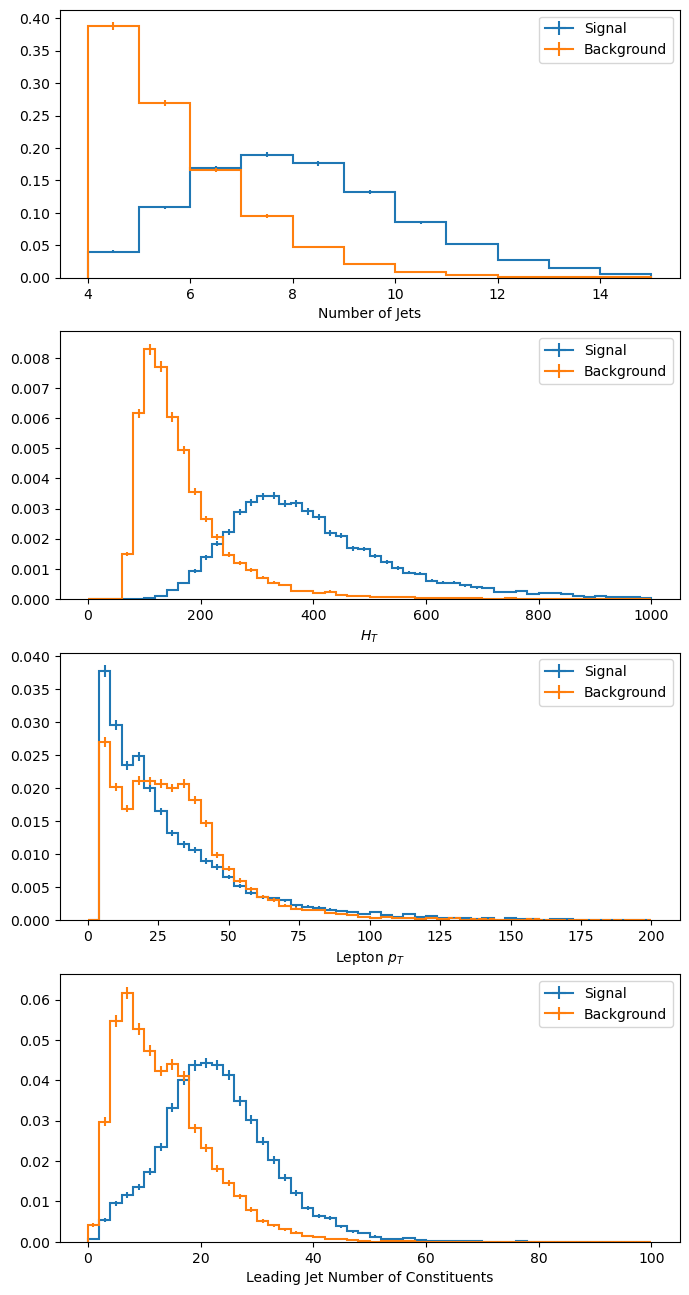

In [8]:
### FIRST FOUR FEATURES

# define histogram
h = hist.Hist(
    hist.axis.Regular(11, 4, 15, name="njet", label="Number of Jets", flow=False),
    hist.axis.Regular(50, 0, 1000, name="ht", label="$H_T$", flow=True),
    hist.axis.Regular(50, 0, 200, name="leptonpt", label="Lepton $p_T$", flow=False),
    hist.axis.Regular(50, 0, 100, name="ljnconst", label="Leading Jet Number of Constituents", flow=False),
    hist.axis.StrCategory(["Signal", "Background"], name="truthlabel", label="Truth Label"),
)

# fill histogram
h.fill(njet = features_signal[:,0], ht = features_signal[:,1], 
       leptonpt = features_signal[:,2], ljnconst = features_signal[:,3], 
       truthlabel="Signal")
h.fill(njet = features_background[:,0], ht = features_background[:,1], 
       leptonpt = features_background[:,2], ljnconst = features_background[:,3], 
       truthlabel="Background")

# make plots
fig,axs = plt.subplots(4,1,figsize=(8,16))

h.project("njet","truthlabel").plot(density=True, ax=axs[0])
axs[0].legend()
h.project("ht","truthlabel").plot(density=True, ax=axs[1])
axs[1].legend()
h.project("leptonpt","truthlabel").plot(density=True, ax=axs[2])
axs[2].legend()
h.project("ljnconst","truthlabel").plot(density=True, ax=axs[3])
axs[3].legend()

fig.show()

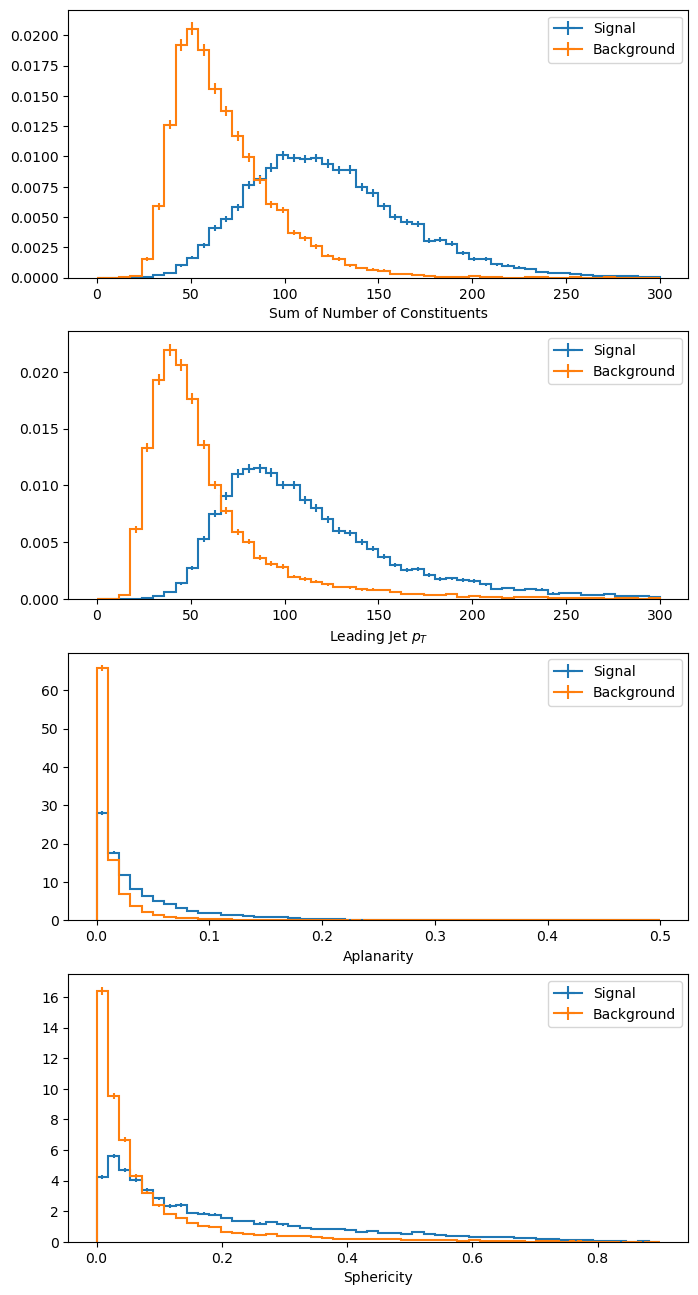

In [9]:
### NEXT FOUR FEATURES

# define histogram
h = hist.Hist(
    hist.axis.Regular(50, 0, 300, name="totalnconst", label="Sum of Number of Constituents", flow=False),
    hist.axis.Regular(50, 0, 300, name="ljpt", label="Leading Jet $p_T$", flow=False),
    hist.axis.Regular(50, 0, 0.5, name="aplanarity", label="Aplanarity", flow=False),
    hist.axis.Regular(50, 0, 0.9, name="sphericity", label="Sphericity", flow=False),
    hist.axis.StrCategory(["Signal", "Background"], name="truthlabel", label="Truth Label"),
)

# fill histogram
h.fill(totalnconst = features_signal[:,4], ljpt = features_signal[:,5], 
       aplanarity = features_signal[:,6], sphericity = features_signal[:,7],
       truthlabel="Signal")
h.fill(totalnconst = features_background[:,4], ljpt = features_background[:,5], 
       aplanarity = features_background[:,6], sphericity = features_background[:,7],
       truthlabel="Background")

fig,axs = plt.subplots(4,1,figsize=(8,16))

h.project("totalnconst","truthlabel").plot(density=True, ax=axs[0])
axs[0].legend()
h.project("ljpt","truthlabel").plot(density=True, ax=axs[1])
axs[1].legend()
h.project("aplanarity","truthlabel").plot(density=True, ax=axs[2])
axs[2].legend()
h.project("sphericity","truthlabel").plot(density=True, ax=axs[3])
axs[3].legend()

fig.show()

In [10]:
### LAST TWO FEATURES

# define histogram
h = hist.Hist(
    hist.axis.Regular(50, 0, 8, name="ljlepdeltar", label="$\Delta R$ Between Leading Jet and Lepton", flow=False),
    hist.axis.Regular(50, 0, 8, name="twoljdeltar", label="$\Delta R$ Between Two Leading Jets", flow=False),
    hist.axis.StrCategory(["Signal", "Background"], name="truthlabel", label="Truth Label"),
)

# fill histogram
h.fill(ljlepdeltar = features_signal[:,8], twoljdeltar = features_signal[:,9], 
       truthlabel="Signal")
h.fill(ljlepdeltar = features_background[:,8], twoljdeltar = features_background[:,9], 
       truthlabel="Background")

fig,axs = plt.subplots(2,1,figsize=(8,8))

h.project("ljlepdeltar","truthlabel").plot(density=True, ax=axs[0])
axs[0].legend()
h.project("twoljdeltar","truthlabel").plot(density=True, ax=axs[1])
axs[1].legend()

fig.show()

___
### Preprocess and Split Events into Train/Test/Split

In [11]:
# re-combine events
features = np.concatenate((features_signal, features_background))
even = np.concatenate((even_signal, even_background))
labels = np.concatenate((np.ones(len(even_signal)), np.zeros(len(even_background))))

In [12]:
# separate dataset into even and odd features
features_even = features[even]
labels_even = labels[even]

features_odd = features[np.invert(even)]
labels_odd = labels[np.invert(even)]


# shuffle events
shuffle_ind_even = list(range(len(labels_even)))
np.random.shuffle(shuffle_ind_even)
features_even = features_even[shuffle_ind_even]
labels_even = labels_even[shuffle_ind_even]

shuffle_ind_odd = list(range(len(labels_odd)))
np.random.shuffle(shuffle_ind_odd)
features_odd = features_odd[shuffle_ind_odd]
labels_odd = labels_odd[shuffle_ind_odd]

print("% Signal for Even-Numbered Events = ", 100*np.average(labels_even))
print("% Signal for Odd-Numbered Events = ", 100*np.average(labels_odd))

% Signal for Even-Numbered Events =  49.70423176095859
% Signal for Odd-Numbered Events =  50.293453724604966


In [13]:
# preprocess features so that they are more Gaussian-like
power = PowerTransformer(method='yeo-johnson', standardize=True) #define preprocessor

features_odd = power.fit_transform(features_odd)
features_even = power.fit_transform(features_even)

___
### Set up MLFlow

In [58]:
# function to provide necessary environment variables to workers
def initialize_mlflow(): 
    
    os.system("pip install boto3")

    os.environ['MLFLOW_TRACKING_URI'] = "https://mlflow.software-dev.ncsa.cloud"
    os.environ['MLFLOW_S3_ENDPOINT_URL'] = "https://mlflow-minio-api.software-dev.ncsa.cloud"
    os.environ['AWS_ACCESS_KEY_ID'] = "bengal1"
    os.environ['AWS_SECRET_ACCESS_KEY'] = "leftfoot1"
    
    mlflow.set_tracking_uri('https://mlflow.software-dev.ncsa.cloud') 
    mlflow.set_experiment("agc-training-demo")

In [30]:
# set up trials

if USE_MLFLOW:
    mlflow.set_tracking_uri('https://mlflow.software-dev.ncsa.cloud') 
    mlflow.set_experiment("agc-training-demo") # this will create the experiment if it does not yet exist

    # grab experiment
    current_experiment=dict(mlflow.get_experiment_by_name("agc-training-demo"))
    experiment_id=current_experiment['experiment_id']
    print("experiment_id = ", experiment_id)

    # create runs ahead of time (avoids conflicts when parallelizing mlflow logging)
    run_id_list=[]
    for n in range(N_TRIALS*2):
        run = MlflowClient().create_run(experiment_id=experiment_id, run_name=f"run-{n}")
        run_id_list.append(run.info.run_id)

    #after running the above lines, you should be able to see the runs at https://mlflow.software-dev.ncsa.cloud/#/experiments/10/

experiment_id =  15


In [ ]:
# make directory to save models for triton to
if not os.path.isdir(f"/mnt/{MODEL_NAME}"):
    os.mkdir(f"/mnt/{MODEL_NAME}")
!ls /mnt/

___
### Training/Hyperparameter Optimization

In [32]:
# generate N_TRIALS random samples from parameter space 
sampler = ParameterSampler(
    {
        'max_depth': np.arange(2, 50, 2, dtype=int), # maximum tree depth
        'n_estimators': np.arange(2, 700, 20, dtype=int), # number of boosting rounds
        'learning_rate': np.logspace(-5, 1, 10), # boosted learning rate
        'min_child_weight': np.linspace(0, 1000, 20), # minimum weight needed in child
        'reg_lambda': [0, 0.25, 0.5, 0.75, 1], # L2 weight regularization
        'reg_alpha': [0, 0.25, 0.5, 0.75, 1], # L1 weight regularization
        'gamma': np.logspace(-4, 2, 20), # minimum loss reduction to make split in tree
        'booster': ['gbtree'], # which booster to use
    },
    n_iter = N_TRIALS, # number of trials to perform
    random_state=1,
) 

samples_even = list(sampler)
samples_odd = list(sampler)

# add additional info to each trial
for i in range(N_TRIALS):
    samples_even[i]['trial_num'] = i
    samples_even[i]['parity'] = 'even' # categorizes this trial as for even event numbers
    
    samples_odd[i]['trial_num'] = i
    samples_odd[i]['parity'] = 'odd' # categorizes this trial as for odd event numbers
    
    if USE_MLFLOW: 
        samples_even[i]['run_id'] = run_id_list[i]
        samples_odd[i]['run_id'] = run_id_list[i+N_TRIALS]
    
print("Example of Trial Parameters: ")
samples_even[0]

Example of Trial Parameters: 


{'reg_lambda': 0.25,
 'reg_alpha': 0.25,
 'n_estimators': 502,
 'min_child_weight': 736.8421052631578,
 'max_depth': 8,
 'learning_rate': 1e-05,
 'gamma': 0.29763514416313164,
 'booster': 'gbtree',
 'trial_num': 0,
 'parity': 'even',
 'run_id': '094907b6d9e1454b9b57338fa0af720f'}

In [45]:
def fit_model(params, features, labels, cv, mlflowclient=None, use_mlflow=True, model_logging=True): 
    
    trial_num = params["trial_num"]
    parity = params["parity"]
    
    if use_mlflow:
        run_id = params["run_id"]
            
        for param, value in params.items(): 
            mlflowclient.log_param(run_id, param, value) 
            
    # remove parameters that are not used for XGBClassifier
    params_copy = params.copy()
    params_copy.pop("trial_num")
    params_copy.pop("run_id")
    params_copy.pop("parity")
            
    # initialize model with current trial paramters
    model = XGBClassifier(random_state=5, 
                          nthread=-1,
                          **params_copy) 

    # perform n-fold cross-validation
    result = cross_validate(model, features, labels, 
                            scoring=['roc_auc','accuracy','precision','f1','recall'], 
                            cv=cv, n_jobs=-1, 
                            return_train_score=True, return_estimator=True)
    
    trial_metrics = {
        "avg_train_roc_auc": result['train_roc_auc'].mean(), 
        "avg_train_accuracy": result['train_accuracy'].mean(), 
        "avg_train_precision": result['train_precision'].mean(), 
        "avg_train_f1": result['train_f1'].mean(), 
        "avg_train_recall": result['train_recall'].mean(), 
        "avg_test_roc_auc": result['test_roc_auc'].mean(), 
        "avg_test_accuracy": result['test_accuracy'].mean(), 
        "avg_test_precision": result['test_precision'].mean(), 
        "avg_test_f1": result['test_f1'].mean(), 
        "avg_test_recall": result['test_recall'].mean(), 
        "avg_fit_time": result['fit_time'].mean(),
        "avg_score_time": result['score_time'].mean(),
    }
    
    if use_mlflow:
        
        for metric, value in trial_metrics.items():
            # log timing metrics
            mlflowclient.log_metric(run_id, metric, value)

        # manually end run
        mlflowclient.set_terminated(run_id)
            
    # fit model with all events
    model.fit(features,labels)

    # log model in mlflow
    if model_logging and use_mlflow:
        signature = infer_signature(features, model.predict(features))
        with mlflow.start_run(run_id=run_id, nested=True) as run:
            mlflow.xgboost.log_model(model, "model", signature=signature)
    
    if model_logging:
        return {'score': result['test_roc_auc'].mean()}
    
    else: # return models as well if we do not log in mlflow
        return {'score': result['test_roc_auc'].mean(),
                'model': model,
                'all_metrics': trial_metrics}

In [46]:
# folds to use for cross-validation
folds = KFold(N_FOLD, random_state=5, shuffle=True)

# set mlflowclient
mlflowclient = MlflowClient()

In [ ]:
# set up dask client
if USE_DASK_ML:
    client = utils.get_client()
    client.run(initialize_mlflow)

In [48]:
## MODEL 1 OPTIMIZATION

if USE_DASK_ML:
    start_time = time.time() 
    futures = client.map(fit_model,
                         samples_even, 
                         features=features_even[:N_TRAIN,:], 
                         labels=labels_even[:N_TRAIN],
                         cv=folds,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         model_logging=MODEL_LOGGING) 
    
    res = client.gather(futures) 
    time_elapsed = time.time() - start_time
        
else:
    start_time = time.time() 
    res = np.zeros(len(samples_even))
    for i in range(len(samples_even)):
        res[i] = fit_model(samples_even[i], 
                           features=features_even[:N_TRAIN,:],
                           labels=labels_even[:N_TRAIN], 
                           cv=folds,
                           mlflowclient=mlflowclient,
                           use_mlflow=USE_MLFLOW,
                           model_logging=MODEL_LOGGING)
        
    time_elapsed = time.time() - start_time
    
print("Hyperparameter optimization took time = ", time_elapsed)

scores = [res[i]['score'] for i in range(N_TRIALS)]
print("Highest AUC = ", max(scores))
print("Parameters for Model with Highest AUC = ")
samples_even[np.argmax(scores)]

Hyperparameter optimization took time =  22.939964532852173
Highest AUC =  0.9555297656474304
Parameters for Model with Highest AUC = 


{'reg_lambda': 0.25,
 'reg_alpha': 0.75,
 'n_estimators': 382,
 'min_child_weight': 52.63157894736842,
 'max_depth': 20,
 'learning_rate': 0.46415888336127725,
 'gamma': 0.01623776739188721,
 'booster': 'gbtree',
 'trial_num': 8,
 'parity': 'even',
 'run_id': 'ca16dcce8f54489e97029d33c844d4a2'}

In [49]:
# load best model
if MODEL_LOGGING:
    best_run_id = samples_even[np.argmax(scores)]['run_id']
    best_model_path = f'runs:/{best_run_id}/model'
    best_model = mlflow.xgboost.load_model(best_model_path)
else:
    best_run_id = samples_even[np.argmax(scores)]['run_id']
    best_model = res[np.argmax(scores)]['model']

In [50]:
predictions_train = best_model.predict(features_even)
predictions_test = best_model.predict(features_odd)

print("Train Accuracy = ", accuracy_score(predictions_train[:N_TRAIN], labels_even[:N_TRAIN]))
print("Train Precision = ", precision_score(predictions_train[:N_TRAIN], labels_even[:N_TRAIN]))
print("Train f1 = ", f1_score(predictions_train[:N_TRAIN], labels_even[:N_TRAIN]))
print("Train Recall = ", recall_score(predictions_train[:N_TRAIN], labels_even[:N_TRAIN]))
print("Train ROC_AUC = ", roc_auc_score(predictions_train[:N_TRAIN], labels_even[:N_TRAIN]))
print()
print("Test Accuracy = ", accuracy_score(predictions_test, labels_odd))
print("Test Precision = ", precision_score(predictions_test, labels_odd))
print("Test f1 = ", f1_score(predictions_test, labels_odd))
print("Test Recall = ", recall_score(predictions_test, labels_odd))
print("Test ROC_AUC = ", roc_auc_score(predictions_test, labels_odd))

Train Accuracy =  0.9687
Train Precision =  0.9723344103392568
Train f1 =  0.9685205672332293
Train Recall =  0.9647365257463434
Train ROC_AUC =  0.9686928785649266

Test Accuracy =  0.8906696764484575
Test Precision =  0.8886894075403949
Test f1 =  0.891022275556889
Test Recall =  0.8933674236727327
Test ROC_AUC =  0.8906680515442417


In [51]:
# load best model into model registry
if MODEL_LOGGING:
    result = mlflow.register_model(best_model_path, "sig-bkg-bdt")

In [ ]:
# save registered model to triton directory
if len(os.listdir(f"/mnt/{MODEL_NAME}"))==0 or WRITE_OVER:
    model_version=1
else:
    model_version=int(max(next(os.walk(f"/mnt/{MODEL_NAME}"))[1]))+1

if not WRITE_OVER:
    os.mkdir(f"/mnt/{MODEL_NAME}/{model_version}")
    
    
print(f"Saving Model to /mnt/{MODEL_NAME}/{model_version}/xgboost.model")
best_model.save_model(f"/mnt/{MODEL_NAME}/{model_version}/xgboost.model")

In [53]:
## MODEL 2 OPTIMIZATION

if USE_DASK_ML:
    start_time = time.time() 
    futures = client.map(fit_model,
                         samples_odd, 
                         features=features_odd[:N_TRAIN,:], 
                         labels=labels_odd[:N_TRAIN],
                         cv=folds,
                         mlflowclient=mlflowclient,
                         use_mlflow=USE_MLFLOW,
                         model_logging=MODEL_LOGGING) 
    
    res = client.gather(futures) 
    time_elapsed = time.time() - start_time
        
else:
    start_time = time.time() 
    res = np.zeros(len(samples_odd))
    for i in range(len(samples_odd)):
        res[i] = fit_model(samples_odd[i], 
                           features=features_odd[:N_TRAIN,:],
                           labels=labels_odd[:N_TRAIN], 
                           cv=folds,
                           mlflowclient=mlflowclient,
                           use_mlflow=USE_MLFLOW,
                           model_logging=MODEL_LOGGING)
        
    time_elapsed = time.time() - start_time
    
print("Hyperparameter optimization took time = ", time_elapsed)

scores = [res[i]['score'] for i in range(N_TRIALS)]
print("Highest AUC = ", max(scores))
print("Parameters for Model with Highest AUC = ")
samples_odd[np.argmax(scores)]

Hyperparameter optimization took time =  29.643147945404053
Highest AUC =  0.9561495431371775
Parameters for Model with Highest AUC = 


{'reg_lambda': 0.25,
 'reg_alpha': 0.75,
 'n_estimators': 382,
 'min_child_weight': 52.63157894736842,
 'max_depth': 20,
 'learning_rate': 0.46415888336127725,
 'gamma': 0.01623776739188721,
 'booster': 'gbtree',
 'trial_num': 8,
 'parity': 'odd',
 'run_id': '81ee7a5a20b340a7bae11bfeb84e3dbc'}

In [54]:
# load best model
if MODEL_LOGGING:
    best_run_id = samples_odd[np.argmax(scores)]['run_id']
    best_model_path = f'runs:/{best_run_id}/model'
    best_model = mlflow.xgboost.load_model(best_model_path)
else:
    best_run_id = samples_odd[np.argmax(scores)]['run_id']
    best_model = res[np.argmax(scores)]['model']

In [55]:
predictions_train = best_model.predict(features_odd)
predictions_test = best_model.predict(features_even)

print("Train Accuracy = ", accuracy_score(predictions_train[:N_TRAIN], labels_odd[:N_TRAIN]))
print("Train Precision = ", precision_score(predictions_train[:N_TRAIN], labels_odd[:N_TRAIN]))
print("Train f1 = ", f1_score(predictions_train[:N_TRAIN], labels_odd[:N_TRAIN]))
print("Train Recall = ", recall_score(predictions_train[:N_TRAIN], labels_odd[:N_TRAIN]))
print("Train ROC_AUC = ", roc_auc_score(predictions_train[:N_TRAIN], labels_odd[:N_TRAIN]))
print()
print("Test Accuracy = ", accuracy_score(predictions_test, labels_even))
print("Test Precision = ", precision_score(predictions_test, labels_even))
print("Test f1 = ", f1_score(predictions_test, labels_even))
print("Test Recall = ", recall_score(predictions_test, labels_even))
print("Test ROC_AUC = ", roc_auc_score(predictions_test, labels_even))

Train Accuracy =  0.9708
Train Precision =  0.9761003784106752
Train f1 =  0.9710719239151973
Train Recall =  0.9660950128129312
Train ROC_AUC =  0.9708697105875088

Test Accuracy =  0.8914758076748066
Test Precision =  0.9021971315227342
Test f1 =  0.8920570264765784
Test Recall =  0.8821423243323885
Test ROC_AUC =  0.8916341731179142


In [56]:
# load best model into model registry
if MODEL_LOGGING:
    result = mlflow.register_model(best_model_path, "sig-bkg-bdt")

In [ ]:
# save registered model to triton directory
if len(os.listdir(f"/mnt/{MODEL_NAME}"))==0:
    model_version=1
else:
    model_version=int(max(next(os.walk(f"/mnt/{MODEL_NAME}"))[1]))+1
if WRITE_OVER:
    if not os.path.isdir(f"/mnt/{MODEL_NAME}/{model_version}"):
        os.mkdir(f"/mnt/{MODEL_NAME}/{model_version}")
    model_version=2
    
if not WRITE_OVER:
    os.mkdir(f"/mnt/{MODEL_NAME}/{model_version}")
    
print(f"Saving Model to /mnt/{MODEL_NAME}/{model_version}/xgboost.model")
best_model.save_model(f"/mnt/{MODEL_NAME}/{model_version}/xgboost.model")

After running hyperparameter optimization for both models, we can view the results of the trials at [this link](https://mlflow.software-dev.ncsa.cloud/#/experiments/10/s?searchInput=&orderByKey=metrics.%60avg_test_roc_auc%60&orderByAsc=false&startTime=ALL&lifecycleFilter=Active&modelVersionFilter=All%20Runs&showMultiColumns=true&categorizedUncheckedKeys%5Battributes%5D%5B0%5D=&categorizedUncheckedKeys%5Bparams%5D%5B0%5D=&categorizedUncheckedKeys%5Bmetrics%5D%5B0%5D=&categorizedUncheckedKeys%5Btags%5D%5B0%5D=&diffSwitchSelected=false&preSwitchCategorizedUncheckedKeys%5Battributes%5D%5B0%5D=&preSwitchCategorizedUncheckedKeys%5Bparams%5D%5B0%5D=&preSwitchCategorizedUncheckedKeys%5Bmetrics%5D%5B0%5D=&preSwitchCategorizedUncheckedKeys%5Btags%5D%5B0%5D=&postSwitchCategorizedUncheckedKeys%5Battributes%5D%5B0%5D=&postSwitchCategorizedUncheckedKeys%5Bparams%5D%5B0%5D=&postSwitchCategorizedUncheckedKeys%5Bmetrics%5D%5B0%5D=&postSwitchCategorizedUncheckedKeys%5Btags%5D%5B0%5D=). The best models can be seen at the top of the list with links to their associated registered models.

___
### Create Triton config file for our model

In [32]:
config_txt = utils.generate_triton_config(MODEL_NAME, features_even.shape[1], predict_proba=True)
print(config_txt)

name: "sigbkg_bdt"
backend: "fil"
max_batch_size: 500000
input [
 {
    name: "input__0"
    data_type: TYPE_FP32
    dims: [ 10 ]
  }
]
output [
 {
    name: "output__0"
    data_type: TYPE_FP32
    dims: [ 2 ]
  }
 
]
instance_group [{ kind: KIND_GPU }]
parameters [
  {
    key: "model_type"
    value: { string_value: "xgboost" }
  },
  {
    key: "predict_proba"
    value: { string_value: "true" }
  },
  {
    key: "output_class"
    value: { string_value: "true" }
  },
  {
    key: "threshold"
    value: { string_value: "0.5" }
  },
  {
    key: "algo"
    value: { string_value: "ALGO_AUTO" }
  },
  {
    key: "storage_type"
    value: { string_value: "AUTO" }
  },
  {
    key: "blocks_per_sm"
    value: { string_value: "0" }
  }
]

dynamic_batching { }


In [33]:
# save config file 
with open(f'/mnt/{MODEL_NAME}/config.pbtxt', 'w') as the_file:
    the_file.write(config_txt)

In [34]:
# print contents of triton server model directory
print(os.listdir(f"/mnt/{MODEL_NAME}"))

['3', '2', '4', 'config.pbtxt', '1']
